In [1]:
from astropy.table import Table
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import h5py
import matplotlib.pyplot as plt
from time import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# defining the Dataset class
class train_set(Dataset):
    def __init__(self,file):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        dset = fn['group_1']['data']
        self.x = torch.Tensor(dset[:].T)
        
        # get label
        ydset = self.f['group_1']['label']
        self.y = torch.Tensor(ydset[:].T)
        # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        
        # get error in label # comment out for non-error label runs
        errdset = self.f['group_1']['e_label']
        self.err = torch.Tensor(errdset[:].T)
        
    def __len__(self):
        return self.f['group_1']['data'].shape[1]
  
    def __getitem__(self, index):
        xg = self.x[index]
        yg = self.y[index]
        errg = self.err[index]
        return (xg,yg,errg)

class valid_set(Dataset):
    def __init__(self,file):
        fn = h5py.File(file, 'r')
        self.f = fn
        
        # get data
        dset = self.f['group_2']['data']
        self.x = torch.Tensor(dset[:].T)
        
        # get label
        ydset = self.f['group_2']['label']
        self.y = torch.Tensor(ydset[:].T)
        # torch.from_numpy(y[index]) does not work since y is doubles and not floats.
        
        # get error in label # comment out for non-error label runs
        errdset = self.f['group_2']['e_label']
        self.err = torch.Tensor(errdset[:].T)
        
    def __len__(self):
        return self.f['group_2']['data'].shape[1]
  
    def __getitem__(self, index):
        xg = self.x[index]
        yg = self.y[index]
        errg = self.err[index]
        return (xg,yg,errg)

In [4]:
class ResBlock(nn.Module):
    def __init__(self, nodes):
        super(ResBlock, self).__init__()
        self.res_block1 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
            nn.LeakyReLU(),
        )
        self.res_block2 = nn.Sequential(
            nn.Linear(nodes,nodes),
            nn.BatchNorm1d(nodes),
        )
        self.lrelu = nn.LeakyReLU()
    
    def forward(self, x):
        res = x
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = x + res
        output = self.lrelu(x)
        return output
        
class ResNetMcK(nn.Module):
    def __init__(self):
        super(ResNetMcK, self).__init__()
        self.input_block = nn.Sequential(
            nn.Linear(3,16),
            nn.LeakyReLU(),
        )
        self.blocklist = nn.ModuleList([
            ResBlock(16),
            ResBlock(16),
            nn.Linear(16,32),
            ResBlock(32),
            ResBlock(32),
            nn.Linear(32,64),
            ResBlock(64),
            ResBlock(64),
            nn.Linear(64,128),
            ResBlock(128),
            ResBlock(128),
        ])
        self.output_block = nn.Sequential(
            nn.Linear(128,110),
        )
        
    def forward(self,x):
        x = self.input_block(x)
        for i, _ in enumerate(self.blocklist):
            x = self.blocklist[i](x)
        logits = self.output_block(x)
        return logits

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 110),
            nn.Sigmoid(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [5]:
training_data = train_set("/arc/home/aydanmckay/elabelssmallcutdatascaled.h5")
valid_data = valid_set("/arc/home/aydanmckay/elabelssmallcutdatascaled.h5")

In [6]:
batchlen = 16
train_dataloader = DataLoader(
    training_data,
    batch_size=batchlen,
    # shuffle=True
    num_workers=0
)
valid_dataloader = DataLoader(
    valid_data,
    batch_size=batchlen,
    num_workers=0
    # shuffle=True
)


In [7]:
model = ResNetMcK()
model = model.to(device)
# print(model)

In [8]:
lr = 1e-2
epochs = 100

In [9]:
# loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss()
# loss_fn = nn.GaussianNLLLoss()

In [10]:
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=lr,
    momentum=0.9
)
# optimizer = torch.optim.Adam(
#     model.parameters(),
#     lr=lr
# )
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=1,
    gamma=0.995
)

In [11]:
def res(preds,dataloader,epoch,resi='rel'):
    fig, axs = plt.subplots(110)
    fig.set_figheight(600)
    
    with torch.no_grad():
        for num, (X, y, z) in enumerate(dataloader):
            if resi == 'rel':
                residual = (y-preds[num])/y
                string = 'Relative Residual'
            elif resi == 'err':
                residual = (y-preds[num])/z
                string = 'Residual Over Label Error'
            elif resi == 'res':
                residual = y-preds[num]
                string = 'Residual'
            for it in range(len(y.T)):
                axs[it].plot(y.T[it],residual.T[it],'k.',alpha=0.1)
                axs[it].set_xlabel('Observed XP Coefficient Value')
                axs[it].set_ylabel('Relative Residual')
                axs[it].set_title('XP Coefficient '+str(it+1)+' '+string)
                
    plt.savefig('/arc/home/aydanmckay/torchplots/test'+resi+'residualsWL1smallepoch'+str(epoch)+'scalecutsep5.png')
    plt.close()
    
def diagplot(preds,dataloader,epoch):
    # fig, axs = plt.subplots(110)
    # fig.set_figheight(600)
    data = []
    labels = []
    with torch.no_grad():
        for num, (X, y, z) in enumerate(dataloader):
            for datum,true in zip(X,y):
                data.append(datum)
                labels.append(true)
        plt.scatter([datum[0] for datum in data],[(pred[0]-y[0])/y[0] for pred,y in zip(preds,labels)],label='Bp Coefficient 1')
        plt.scatter([datum[0] for datum in data],[(pred[54]-y[54])/y[54] for pred,y in zip(preds,labels)],label='Rp Coefficient 1')
        
            # for it in range(len(y.T)):
            #     axs[it].plot(y.T[it],pred.T[it],'k.',alpha=0.1)
            #     axs[it].set_xlabel('Observed')
            #     axs[it].set_ylabel('Predicted')
            #     axs[it].set_title('XP Coefficient '+str(it+1))
        plt.legend()
        plt.title('BP and RP Coefficient 1')
        plt.xlabel('Teff')
        plt.ylabel('Relative Residual')
        plt.savefig('/arc/home/aydanmckay/torchresplots/test'+str(epoch)+'diagplot.png')
        plt.close()

In [12]:
def train(dataloader, model, loss_fn, optimizer, scheduler, device):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.
    for batch, (X, y, z) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        # z = z.to(device)
        
        pred = model(X)
        loss = loss_fn(pred,y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if (batch % 1000 == 0) and (batch != 0):
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {running_loss/batch:>7f}  [{current:>5d}/{size:>5d}]")
        
    scheduler.step()
            
    print(f"loss: {running_loss/len(dataloader):>7f}  [{size:>5d}/{size:>5d}]")
    return running_loss/len(dataloader)

def valid(dataloader, model, loss_fn, epoch, device, plots = False):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    preds = []
    with torch.no_grad():
        for X, y, z in dataloader:
            X = X.to(device)
            y = y.to(device)
            # z = z.to(device)
            
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred == y).type(torch.float).sum().item()
            if plots == True:
                for prediction in pred:
                    preds.append(prediction.to('cpu'))
    
    if plots == True:
        preds = np.array(preds)
        # res(preds,dataloader,epoch,resi='res')
        # res(preds,dataloader,epoch,resi='rel')
        # res(preds,dataloader,epoch,resi='err')
        diagplot(preds,dataloader,epoch)
    
    valid_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    return valid_loss

In [13]:
valloss = []
traloss = []
for t in range(epochs):
    t0 = time()
    print(f"Epoch {t+1}\n-------------------------------")
    trainloss = train(train_dataloader, model, loss_fn, optimizer, scheduler, device)
    if t % 25 == 0:
        validloss = valid(valid_dataloader, model, loss_fn, t, device, plots = True)
    else:
        validloss = valid(valid_dataloader, model, loss_fn, t, device)
    valloss.append(validloss)
    traloss.append(trainloss)
    # torch.save({
    #             'epoch': t,
    #             'model_state_dict': model.state_dict(),
    #             'optimizer_state_dict': optimizer.state_dict(),
    #             'loss': tloss,
    #             }, '/arc/home/aydanmckay/ml/torchnn/checkpoints/checkpointWGLsmallepoch'+str(t)+'scalecutsep5.pth')
    # torch.save(model.state_dict(), "/arc/home/aydanmckay/torchmodel/torchmodelWsmallscalecutsep5iter"+str(t)+".pth")
    t1 = time()
    print(f'Elapsed epoch time: {t1-t0:.2f} s')
print("Training completed")

Epoch 1
-------------------------------
loss: 0.912994  [16000/45000]
loss: 0.895806  [32000/45000]
loss: 0.881752  [45000/45000]


/tmp/ipykernel_1328751/154121105.py:49: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  preds = np.array(preds)
/tmp/ipykernel_1328751/154121105.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  preds = np.array(preds)


Test Error: 
 Accuracy: 0.0%, Avg loss: 0.834674 

Elapsed epoch time: 29.23 s
Epoch 2
-------------------------------
loss: 0.856738  [16000/45000]
loss: 0.856729  [32000/45000]
loss: 0.849592  [45000/45000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.827429 

Elapsed epoch time: 25.66 s
Epoch 3
-------------------------------
loss: 0.844546  [16000/45000]
loss: 0.845810  [32000/45000]
loss: 0.839500  [45000/45000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.824150 

Elapsed epoch time: 23.80 s
Epoch 4
-------------------------------
loss: 0.837492  [16000/45000]
loss: 0.839111  [32000/45000]
loss: 0.833099  [45000/45000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.821369 

Elapsed epoch time: 19.78 s
Epoch 5
-------------------------------
loss: 0.832068  [16000/45000]
loss: 0.834040  [32000/45000]
loss: 0.828188  [45000/45000]
Test Error: 
 Accuracy: 0.0%, Avg loss: 0.819370 

Elapsed epoch time: 22.24 s
Epoch 6
-------------------------------
loss: 0.827770  [16000/45000]
loss: 0.829793 

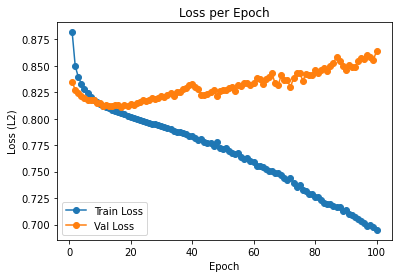

In [14]:
plt.plot(range(1,len(traloss)+1),traloss,'-o',label='Train Loss')
plt.plot(range(1,len(valloss)+1),valloss,'-o',label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (L2)')
# plt.ylim(0.65,0.67)
plt.legend(fancybox=True)
plt.title('Loss per Epoch')
plt.savefig('/arc/home/aydanmckay/torchresplots/lossL2smallscalecutsbl16lr-2SGDep100.png')
plt.show()

In [15]:
torch.save(model.state_dict(), "/arc/home/aydanmckay/torchresmodel/modelL2smallscalecutsbl16lr-2SGDep100.pth")